Loading enrolment...
Loading demographic...
Loading biometric...
Merging data...

Top Anomaly: Mahasamund
Critical Gap: Pashchim Champaran


C:\Users\vinay\AppData\Local\Temp\ipykernel_15612\515784995.py:79: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax1 = sns.barplot(x='inflow_ratio', y='district', data=top_anomalies, palette=colors)


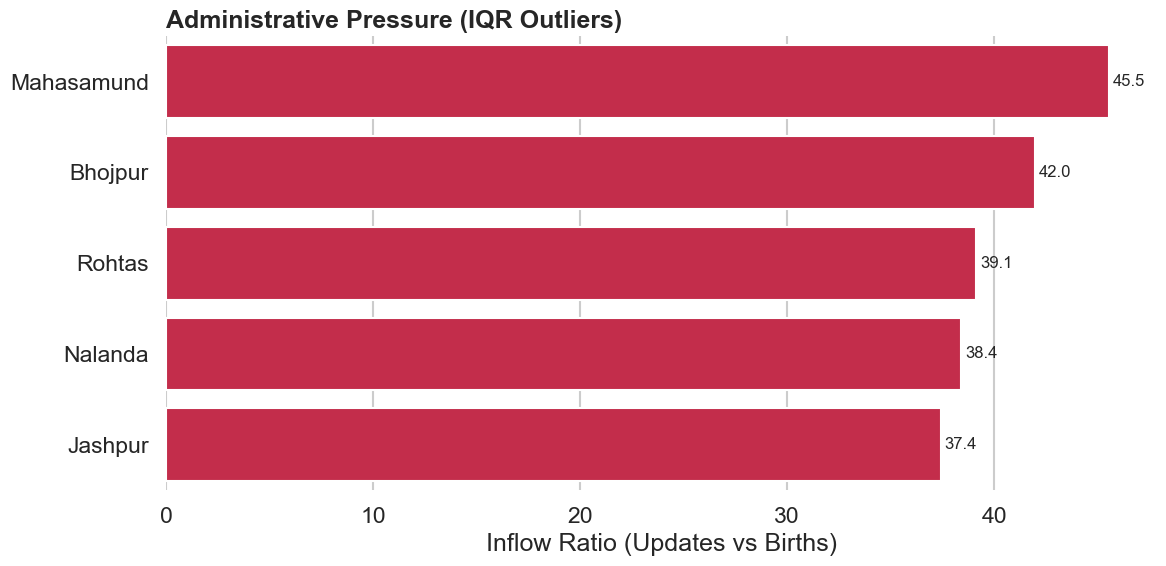

C:\Users\vinay\AppData\Local\Temp\ipykernel_15612\515784995.py:93: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax2 = sns.barplot(x='compliance', y='district', data=top_gaps, palette="autumn")


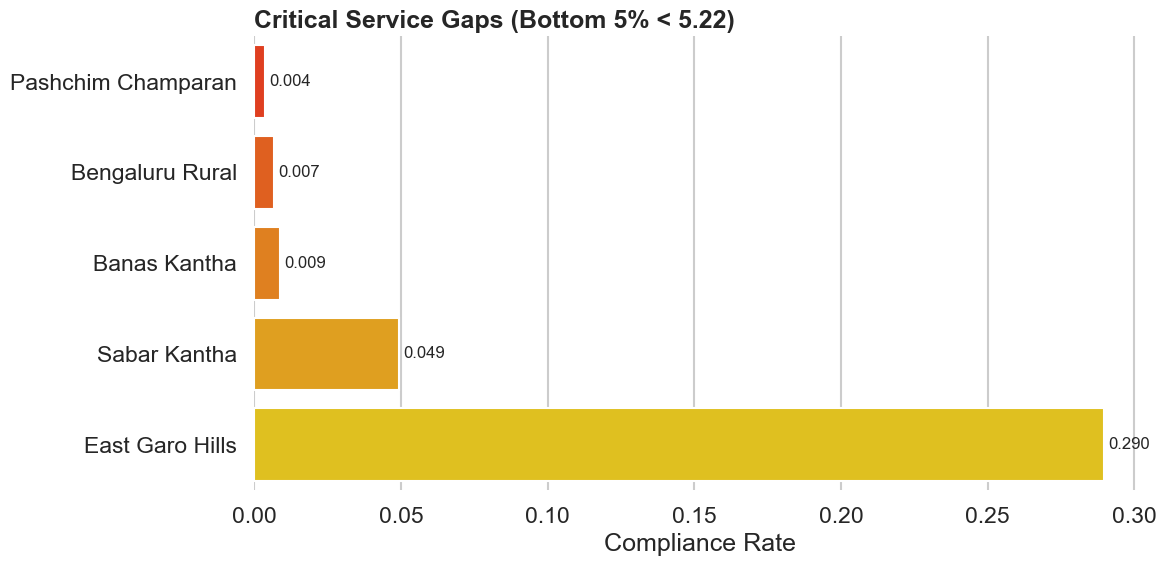

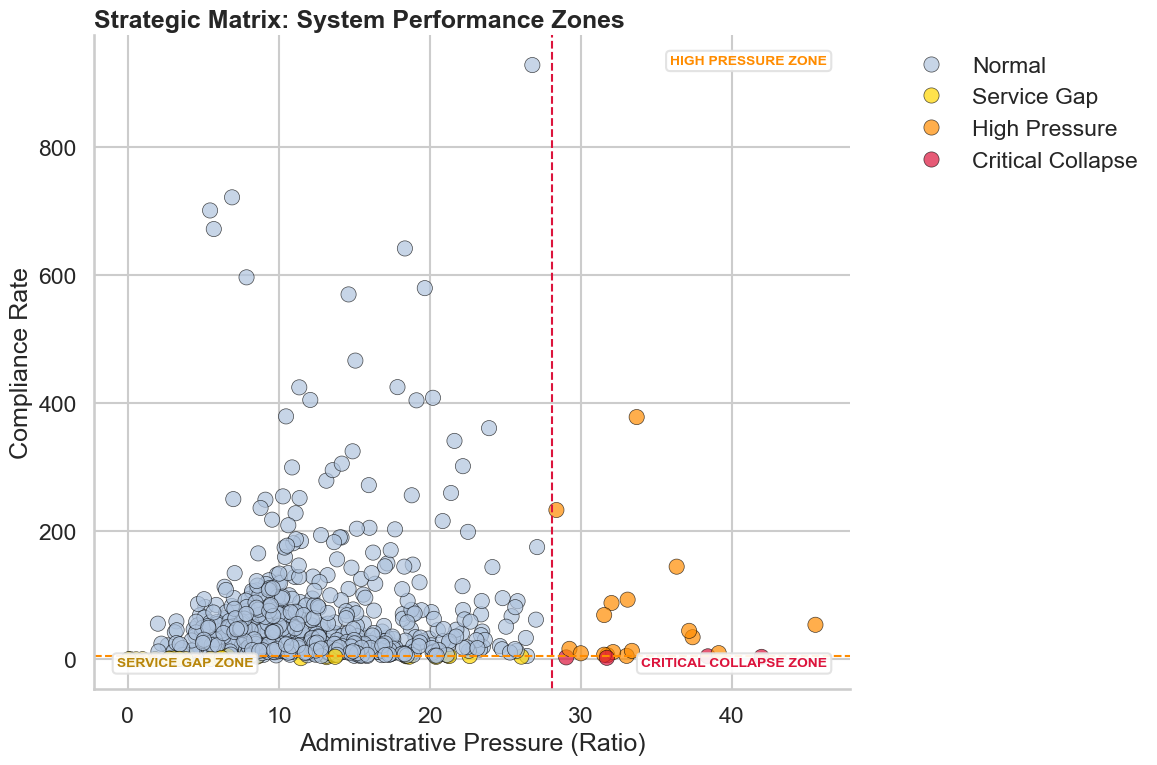

In [9]:
import pandas as pd
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load data
def get_dataset(keyword):
    print(f"Loading {keyword}...")
    path = os.path.join("Data", "**", f"*{keyword}*.csv")
    files = glob.glob(path, recursive=True)
    
    if not files:
        return pd.DataFrame()
    
    dfs = []
    for f in files:
        try:
            df = pd.read_csv(f, low_memory=False)
            df.columns = df.columns.str.strip().str.lower()
            dfs.append(df)
        except:
            pass 
            
    if dfs:
        return pd.concat(dfs, ignore_index=True)
    return pd.DataFrame()

df_enrol = get_dataset("enrolment")
df_demo = get_dataset("demographic")
df_bio = get_dataset("biometric")

# 2. Merge datasets
print("Merging data...")

grp_enrol = df_enrol.groupby(['state', 'district'])[['age_0_5', 'age_5_17']].sum().reset_index()

grp_demo = df_demo.groupby(['state', 'district'])[['demo_age_17_']].sum().reset_index()
grp_demo.rename(columns={'demo_age_17_': 'adult_updates'}, inplace=True)

grp_bio = df_bio.groupby(['state', 'district'])[['bio_age_5_17']].sum().reset_index()
grp_bio.rename(columns={'bio_age_5_17': 'child_bio_updates'}, inplace=True)

merged = pd.merge(grp_enrol, grp_demo, on=['state', 'district'])
merged = pd.merge(merged, grp_bio, on=['state', 'district'])

# 3. Robust Statistical Analysis (IQR)
df = merged[merged['age_0_5'] > 1000].copy()

# calculate ratios
df['inflow_ratio'] = df['adult_updates'] / df['age_0_5'].replace(0, np.nan)
df['compliance'] = df['child_bio_updates'] / df['age_5_17'].replace(0, np.nan)

# calculate IQR for pressure
Q1_inflow = df['inflow_ratio'].quantile(0.25)
Q3_inflow = df['inflow_ratio'].quantile(0.75)
IQR_inflow = Q3_inflow - Q1_inflow
pressure_threshold = Q3_inflow + (1.5 * IQR_inflow)
df['is_pressure_anomaly'] = df['inflow_ratio'] > pressure_threshold

# calculate bottom 5% for gaps
gap_threshold = df['compliance'].quantile(0.05)
df['is_critical_gap'] = df['compliance'] < gap_threshold

# sort results
top_anomalies = df.sort_values('inflow_ratio', ascending=False).head(5)
top_gaps = df.sort_values('compliance', ascending=True).head(5)

print("\nTop Anomaly:", top_anomalies.iloc[0]['district'])
print("Critical Gap:", top_gaps.iloc[0]['district'])

# 4. Expert Visualization
sns.set_theme(style="whitegrid", context="talk")

# Chart 1: Administrative Pressure
plt.figure(figsize=(12, 6))
colors = ['#DC143C' if x else '#708090' for x in top_anomalies['is_pressure_anomaly']]
ax1 = sns.barplot(x='inflow_ratio', y='district', data=top_anomalies, palette=colors)

for container in ax1.containers:
    ax1.bar_label(container, fmt='%.1f', padding=3, fontsize=12)

plt.title('Administrative Pressure (IQR Outliers)', fontweight='bold', loc='left')
plt.xlabel('Inflow Ratio (Updates vs Births)')
plt.ylabel('')
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()

# Chart 2: Service Gaps
plt.figure(figsize=(12, 6))
ax2 = sns.barplot(x='compliance', y='district', data=top_gaps, palette="autumn")

for container in ax2.containers:
    ax2.bar_label(container, fmt='%.3f', padding=3, fontsize=12)

plt.title(f'Critical Service Gaps (Bottom 5% < {gap_threshold:.2f})', fontweight='bold', loc='left')
plt.xlabel('Compliance Rate')
plt.ylabel('')
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()

# Chart 3: Strategic Matrix
plt.figure(figsize=(12, 8))

def get_zone(row):
    if row['inflow_ratio'] > pressure_threshold and row['compliance'] < gap_threshold:
        return 'Critical Collapse'
    elif row['inflow_ratio'] > pressure_threshold:
        return 'High Pressure'
    elif row['compliance'] < gap_threshold:
        return 'Service Gap'
    else:
        return 'Normal'

df['Zone'] = df.apply(get_zone, axis=1)

zone_colors = {
    'Critical Collapse': '#DC143C', # Crimson
    'High Pressure': '#FF8C00',     # Dark Orange
    'Service Gap': '#FFD700',       # Gold
    'Normal': '#B0C4DE'             # Light Steel Blue
}

sns.scatterplot(
    data=df, x='inflow_ratio', y='compliance', hue='Zone', 
    palette=zone_colors, alpha=0.7, s=120, edgecolor='black', linewidth=0.5
)

plt.axvline(pressure_threshold, color='#DC143C', linestyle='--', linewidth=1.5)
plt.axhline(gap_threshold, color='#FF8C00', linestyle='--', linewidth=1.5)

# Text placement in corners using Axes Coordinates (0-1) so it never overlaps data
# Top Right
plt.text(0.97, 0.97, 'HIGH PRESSURE ZONE', transform=plt.gca().transAxes, 
         color='#FF8C00', fontweight='bold', ha='right', va='top', fontsize=10,
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.9, edgecolor='#E0E0E0'))

# Bottom Right
plt.text(0.97, 0.03, 'CRITICAL COLLAPSE ZONE', transform=plt.gca().transAxes, 
         color='#DC143C', fontweight='bold', ha='right', va='bottom', fontsize=10,
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.9, edgecolor='#E0E0E0'))

# Bottom Left
plt.text(0.03, 0.03, 'SERVICE GAP ZONE', transform=plt.gca().transAxes, 
         color='#B8860B', fontweight='bold', ha='left', va='bottom', fontsize=10,
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.9, edgecolor='#E0E0E0'))

plt.title('Strategic Matrix: System Performance Zones', fontweight='bold', loc='left')
plt.xlabel('Administrative Pressure (Ratio)')
plt.ylabel('Compliance Rate')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False)
sns.despine()
plt.tight_layout()
plt.show()